In [54]:
!python -m pip install descartes
!python -m pip install geopandas
!python -m pip install shapely
import pandas as pd
import re
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
import scipy.stats
import numpy as np
from shapely.geometry import Point, Polygon
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


%matplotlib inline

In [55]:
#Read the data from csv into dataframe
LGA_INFO = pd.read_csv('Data/LGA_2016_VIC.csv')
LGA_SPORT_FACILITY = pd.read_csv('Data/Victoria_Sport_and_Recreation_Facility_Location.csv')
LGA_HEALTH_RISK = pd.read_csv('Data/LGA15_Adults_Health_Risk_Factor_Estimates.csv')
#Cleaning area name and corresponding area code, and make a dictionary
LGA_NAME_TO_CODE = LGA_INFO[['LGA_CODE_2016', 'LGA_NAME_2016']]
LGA_NAME_TO_CODE = LGA_NAME_TO_CODE.drop_duplicates()
LGA_NAME_TO_CODE['LGA_NAME_2016'] = LGA_NAME_TO_CODE['LGA_NAME_2016'].str.replace(r' \([^()]*\)', '', regex=True)
LGA_NAME_TO_CODE['LGA_NAME_2016'] = LGA_NAME_TO_CODE['LGA_NAME_2016'].str.upper()
LGA_DIC = LGA_NAME_TO_CODE.set_index('LGA_NAME_2016')['LGA_CODE_2016'].to_dict()

#Find the corresponding area codes for the sport facilities
area_code = LGA_SPORT_FACILITY['lga'].to_list()
for i in range(len(area_code)):
    if area_code[i] in LGA_DIC:
        area_code[i] = LGA_DIC[area_code[i]]
    else:
        area_code[i] = None

#Print the area names that does not have a corresponding code
# for i in range(len(area_code)):
#     if area_code[i] == None:
#         print(LGA_SPORT_FACILITY['lga'].to_list()[i])

#Add the area codes and clean the sport facility dataframe
LGA_SPORT_FACILITY['lga_code'] = area_code
LGA_SPORT_FACILITY = LGA_SPORT_FACILITY.dropna(subset=['lga_code'])
LGA_SPORT_FACILITY['lga_code'] = LGA_SPORT_FACILITY['lga_code'].astype(dtype='int')

#Group the sport facilities by area code
FACILITY_COUNT_PER_LGA = LGA_SPORT_FACILITY.groupby('lga_code', as_index=False).count()[['lga_code', 'lga']]
#print(FACILITY_COUNT_PER_LGA)

#Join the sport facility dataframe and health risk dataframe together by lga
JOINED = FACILITY_COUNT_PER_LGA.set_index('lga_code').join(LGA_HEALTH_RISK.set_index('lga_code'), on='lga_code', how='left', sort=False)

#Read region population csv
region_population = pd.read_csv('Data/regional_population_csv.csv')

#Join region_population dataframe and JOINED together by lga code
JOINED_2 = JOINED.join(region_population.set_index('lga_code'), on='lga_code', how='left', sort=False)
JOINED_2['num_facility_per_capita(2016)']=JOINED_2['lga']/JOINED_2['population2016']
JOINED_2['num_facility_per_capita(2017)']=JOINED_2['lga']/JOINED_2['population2017']
JOINED_2['num_facility_per_km2']=JOINED_2['lga']/JOINED_2['Area(km2)']

# Remove one outlier with num_facility_perr_km2 > 5
JOINED_2 = JOINED_2[JOINED_2['num_facility_per_km2']<5]

**Regression for lw_excse_2_asr**

Linear

[[ 1.         -0.66308798]
 [-0.66308798  1.        ]]
Coefficients:  [-2.5455855]

Intercept:  68.0385238235378

Coefficient of determination: 0.44


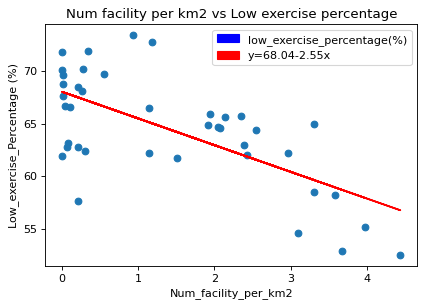

In [56]:
X = JOINED_2[['num_facility_per_km2']]
y = JOINED_2['lw_excse_2_asr']

# correlation matrix
print(np.corrcoef(JOINED_2['num_facility_per_km2'],JOINED_2['lw_excse_2_asr']))

# linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
y_predictions = lm.predict(X)

print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R2
r2_train = lm.score(X, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
from matplotlib.pyplot import figure
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.plot(X, y_predictions, color='red')
colors = ['b','r']      
labels = ['low_exercise_percentage(%)','y=68.04-2.55x']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.title("Num facility per km2 vs Low exercise percentage")
plt.ylabel("Low_exercise_Percentage (%)")
plt.xlabel("Num_facility_per_km2")
plt.savefig("low_exe_l")
plt.show()


quadratic

Coefficients:  [ 0.         1.4706014 -1.1203868]

Intercept:  66.64588417336479

Coefficient of determination: 0.55


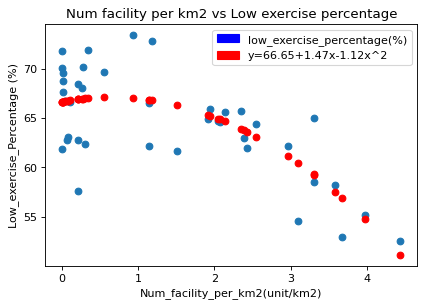

In [57]:
# quadratic linear regression 
polynom = PolynomialFeatures(degree=2)
X_polynom = polynom.fit_transform(X)
poly_reg = linear_model.LinearRegression()
poly_reg.fit(X_polynom, y)
y_predict = poly_reg.predict(polynom.fit_transform(X))

print('Coefficients: ', end = ' ')
print(poly_reg.coef_)
print('')

print('Intercept: ', end = ' ')
print(poly_reg.intercept_)
print('')

r2_train = poly_reg.score(X_polynom, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.scatter(X, y_predict, color='red')
colors = ['b','r']      
labels = ['low_exercise_percentage(%)','y=66.65+1.47x-1.12x^2']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.title("Num facility per km2 vs Low exercise percentage")
plt.ylabel("Low_exercise_Percentage (%)")
plt.xlabel("Num_facility_per_km2(unit/km2)")
plt.savefig("low_exe_q")
plt.show()

quadratic model provides a better fit

**Regression for obese_p_2_asr**

Linear

[[ 1.         -0.85585843]
 [-0.85585843  1.        ]]
Coefficients:  [-3.67266748]

Intercept:  31.26426626437196

Coefficient of determination: 0.73


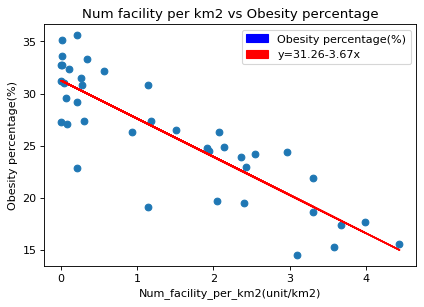

In [58]:
X = JOINED_2[['num_facility_per_km2']]
y = JOINED_2['obese_p_2_asr']

# correlation matrix
print(np.corrcoef(JOINED_2['num_facility_per_km2'],JOINED_2['obese_p_2_asr']))

# linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
y_predictions = lm.predict(X)

print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R2
r2_train = lm.score(X, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.plot(X, y_predictions, color='red')
colors = ['b','r']      
labels = ['Obesity percentage(%)','y=31.26-3.67x']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylabel("Obesity percentage(%)")
plt.xlabel("Num_facility_per_km2(unit/km2)")
plt.title("Num facility per km2 vs Obesity percentage")
plt.savefig("obes_l")
plt.show()

quadratic log-scale

Coefficients:  [ 0.         -4.25529738 -0.69658723]

Intercept:  26.033092293773276

Coefficient of determination: 0.70


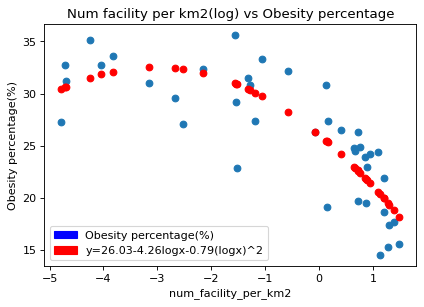

In [59]:
# log-scale quadratic linear regression
X = np.log(JOINED_2[['num_facility_per_km2']])
y = JOINED_2['obese_p_2_asr']
polynom = PolynomialFeatures(degree=2)
X_polynom = polynom.fit_transform(X)
poly_reg = linear_model.LinearRegression()
poly_reg.fit(X_polynom, y)
y_predict = poly_reg.predict(polynom.fit_transform(X))

print('Coefficients: ', end = ' ')
print(poly_reg.coef_)
print('')

print('Intercept: ', end = ' ')
print(poly_reg.intercept_)
print('')

# R2
r2_train = poly_reg.score(X_polynom, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.scatter(X, y_predict, color='red')
colors = ['b','r']      
labels = ['Obesity percentage(%)','y=26.03-4.26logx-0.79(logx)^2']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.title("Num facility per km2(log) vs Obesity percentage")
plt.ylabel("Obesity percentage(%)")
plt.xlabel("num_facility_per_km2")
plt.savefig("obes_q")
plt.show()

linear regression performs better

**Regression for hbld_pres_2_asr**

[[1.        0.2094712]
 [0.2094712 1.       ]]
Coefficients:  [0.62865202]

Intercept:  22.555969133782785

Coefficient of determination: 0.04


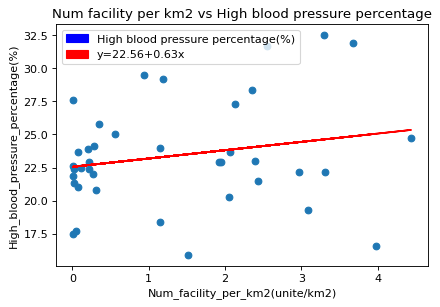

In [66]:
# exclude outliers
JOINED_NoOutlier = JOINED_2[JOINED_2['hbld_pres_2_asr']<35]
X = JOINED_NoOutlier[['num_facility_per_km2']]
y = JOINED_NoOutlier['hbld_pres_2_asr']

# correlation matrix
print(np.corrcoef(JOINED_NoOutlier['num_facility_per_km2'],JOINED_NoOutlier['hbld_pres_2_asr']))

# linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
y_predictions = lm.predict(X)

print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R2
r2_train = lm.score(X, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

#Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.plot(X, y_predictions, color='red')
colors = ['b','r']      
labels = ['High blood pressure percentage(%)','y=22.56+0.63x']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylabel("High_blood_pressure_percentage(%)")
plt.xlabel("Num_facility_per_km2(unite/km2)")
plt.title("Num facility per km2 vs High blood pressure percentage")
plt.savefig("hbp_l")
plt.show()


In [65]:
# F-Test
mse = mean_squared_error(y, y_predictions)
msr = sum((y_predictions-y.mean())*(y_predictions-y.mean()))/1
F = msr/mse
df1 = 1
df2 = JOINED_2.shape[0]-2 
p_value = 1 - scipy.stats.f.cdf(F, df1, df2)
print(p_value)

6.800290941466614e-08


**Regression for psych_dstrs_2_asr**

Linear

[[ 1.         -0.47607278]
 [-0.47607278  1.        ]]
Coefficients:  [-0.83790599]

Intercept:  13.24439771925698

Coefficient of determination: 0.23


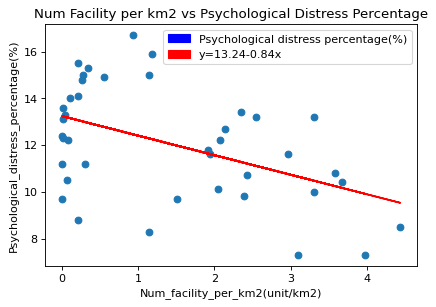

In [61]:
X = JOINED_2[['num_facility_per_km2']]
y = JOINED_2['psych_dstrs_2_asr']

# correlation matrix
print(np.corrcoef(JOINED_2['num_facility_per_km2'],JOINED_2['psych_dstrs_2_asr']))

# linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
y_predictions = lm.predict(X)

print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R2
r2_train = lm.score(X, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.plot(X, y_predictions, color='red')
colors = ['b','r']      
labels = ['Psychological distress percentage(%)','y=13.24-0.84x']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylabel("Psychological_distress_percentage(%)")
plt.xlabel("Num_facility_per_km2(unit/km2)")
plt.title("Num Facility per km2 vs Psychological Distress Percentage")
plt.savefig("psyc_l")
plt.show()

quadratic

Coefficients:  [ 0.          1.59855276 -0.2736239 ]

Intercept:  22.222138510084118

Coefficient of determination: 0.05


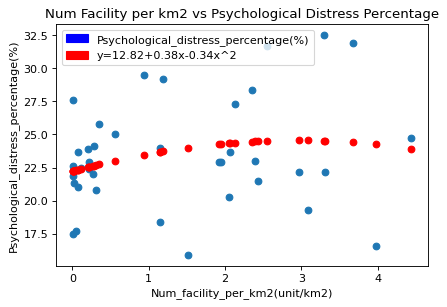

In [68]:
# quadratic linear regression
polynom = PolynomialFeatures(degree=2)
X_polynom = polynom.fit_transform(X)
poly_reg = linear_model.LinearRegression()
poly_reg.fit(X_polynom, y)
y_predict = poly_reg.predict(polynom.fit_transform(X))

print('Coefficients: ', end = ' ')
print(poly_reg.coef_)
print('')

print('Intercept: ', end = ' ')
print(poly_reg.intercept_)
print('')

# R2
r2_train = poly_reg.score(X_polynom, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.scatter(X, y_predict, color='red')
colors = ['b','r']      
labels = ['Psychological_distress_percentage(%)','y=12.82+0.38x-0.34x^2']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylabel("Psychological_distress_percentage(%)")
plt.xlabel("Num_facility_per_km2(unit/km2)")
plt.title("Num Facility per km2 vs Psychological Distress Percentage")
plt.savefig("psyc_q")
plt.show()


In [69]:
# F-Test
import scipy.stats
mse = mean_squared_error(y, y_predict)
msr = sum((y_predict-y.mean())*(y_predict-y.mean()))/1
F = msr/mse
df1 = 2
df2 = JOINED_2.shape[0]-3 
p_value = 1 - scipy.stats.f.cdf(F, df1, df2)
print(p_value)

0.11840896176101257


num. of facility per km2 is statistically significant in modeling num of people with psychological distress

**Regression for smkrs_p_2_asr**

[[ 1.         -0.70782562]
 [-0.70782562  1.        ]]
Coefficients:  [-1.85374028]

Intercept:  17.976893441203515

Coefficient of determination: 0.53


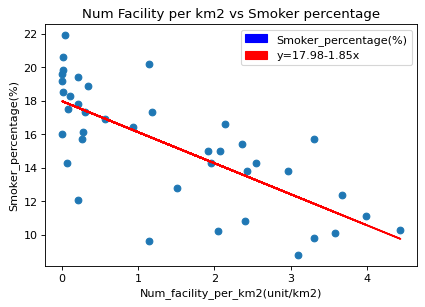

In [70]:

X = JOINED_2[['num_facility_per_km2']]
y = JOINED_2['smkrs_p_2_asr']

# correlation matrix
print(np.corrcoef(JOINED_NoOutlier['num_facility_per_km2'],JOINED_NoOutlier['smkrs_p_2_asr']))

# Linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
y_predictions = lm.predict(X)

print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R2
r2_train = lm.score(X, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.plot(X, y_predictions, color='red')
colors = ['b','r']      
labels = ['Smoker_percentage(%)','y=17.98-1.85x']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylabel("Smoker_percentage(%)")
plt.xlabel("Num_facility_per_km2(unit/km2)")
plt.title("Num Facility per km2 vs Smoker percentage")
plt.savefig("smk_l")
plt.show()

**Regression for alchl_p_2_asr**

[[ 1.         -0.06628064]
 [-0.06628064  1.        ]]
Coefficients:  [-0.1644097]

Intercept:  15.72386817722047

Coefficient of determination: 0.00


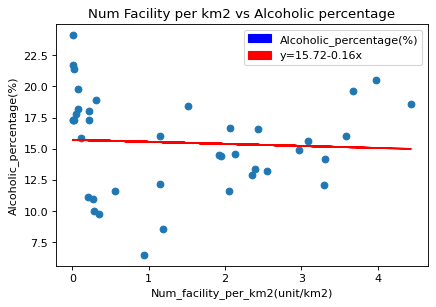

In [71]:

X = JOINED_2[['num_facility_per_km2']]
y = JOINED_2['alchl_p_2_asr']

# correlation matrix
print(np.corrcoef(JOINED_NoOutlier['num_facility_per_km2'],JOINED_NoOutlier['alchl_p_2_asr']))

# linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
y_predictions = lm.predict(X)

print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R2
r2_train = lm.score(X, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.plot(X, y_predictions, color='red')
colors = ['b','r']      
labels = ['Alcoholic_percentage(%)','y=15.72-0.16x']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylabel("Alcoholic_percentage(%)")
plt.xlabel("Num_facility_per_km2(unit/km2)")
plt.title("Num Facility per km2 vs Alcoholic percentage")
plt.savefig("alc_l")
plt.show()

slight association

**Regression for wst_meas_p_2_asr**

[[ 1.         -0.81370185]
 [-0.81370185  1.        ]]
Coefficients:  [-2.79719848]

Intercept:  65.06893621253013

Coefficient of determination: 0.67


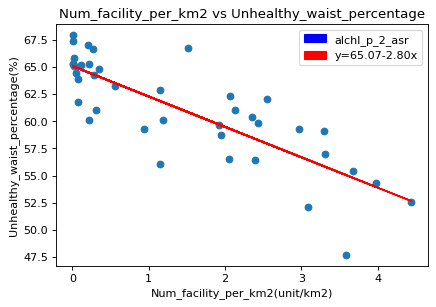

In [72]:
X = JOINED_2[['num_facility_per_km2']]
y = JOINED_2['wst_meas_p_2_asr']

# correlation matrix
print(np.corrcoef(JOINED_NoOutlier['num_facility_per_km2'],JOINED_NoOutlier['wst_meas_p_2_asr']))

# linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
y_predictions = lm.predict(X)

print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R2
r2_train = lm.score(X, y)
print('Coefficient of determination: {0:.2f}'.format(r2_train))

# Plot
figure(figsize=(6, 4), dpi=80)
plt.scatter(X, y)
plt.plot(X, y_predictions, color='red')
colors = ['b','r']      
labels = ['alchl_p_2_asr','y=65.07-2.80x']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylabel("Unhealthy_waist_percentage(%)")
plt.xlabel("Num_facility_per_km2(unit/km2)")
plt.title("Num_facility_per_km2 vs Unhealthy_waist_percentage")
plt.savefig("waist_l")
plt.show()

In [73]:
# percentage of facilities in each LGA by types of sports played
LGA_SPORT_FACILITY['total'] = LGA_SPORT_FACILITY.groupby('lga_code')['lga_code'].transform('count')
GROUPBY_LGA_AND_SPORT = LGA_SPORT_FACILITY.groupby(['lga_code','sportsplayed', 'total']).size().reset_index(name='count')
GROUPBY_LGA_AND_SPORT = GROUPBY_LGA_AND_SPORT.set_index('lga_code').join(LGA_HEALTH_RISK.set_index('lga_code'), on='lga_code', how='left', sort=False)
GROUPBY_LGA_AND_SPORT['percentage'] = GROUPBY_LGA_AND_SPORT['count'] / GROUPBY_LGA_AND_SPORT['total']
TOP = GROUPBY_LGA_AND_SPORT.sort_values(['lw_excse_2_asr', 'lga_code', 'percentage'], ascending=[True, True, False]).groupby('lga_code')
pd.set_option('display.max_rows', 20)


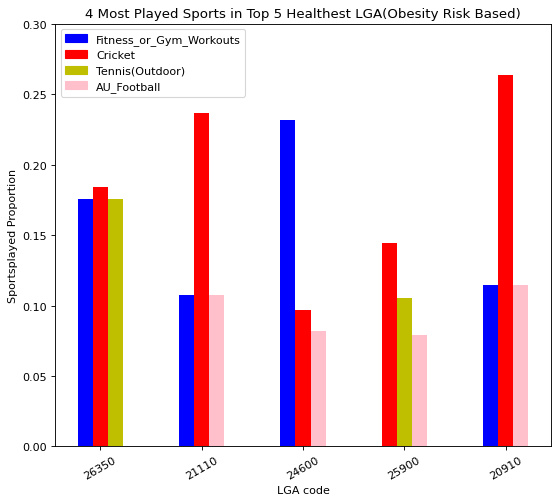

In [74]:
# take average of three obese-related metrics
# select 5 LGA with best performance
JOINED_2 = JOINED_2.reset_index()
JOINED_2['obese_risk'] = JOINED_2[['obese_p_2_asr','lw_excse_2_asr','wst_meas_p_2_asr']].mean(axis=1)
TOP5_LGA = JOINED_2.sort_values('obese_risk').iloc[:5,]['lga_code'].to_list()
# top 3 sports played in each of these 5 LGAs
GROUPBY_LGA_AND_SPORT1 = GROUPBY_LGA_AND_SPORT.loc[TOP5_LGA]
GROUPBY_LGA_AND_SPORT1.sort_values(['lga_code','percentage'],ascending=False).groupby('lga_code').head(3)
# Plot
from matplotlib.pyplot import figure
figure(figsize=(8, 7), dpi=80)
Fitness = [0.175439,0.107527,0.231343,0,0.114865]
Cricket = [0.184211,0.236559,0.097015,0.144737,0.263514]
Tennis_Outerdoor=[0.175439,0,0,0.105263,0]
AU_Football = [0,0.107527,0.082090,0.078947,0.114865]
plt.bar(np.arange(len(Fitness))*2-0.3, Fitness, width=0.3,color='b')
plt.bar(np.arange(len(Cricket))*2-[0,0,0,0.3,0], Cricket, width=0.3, color='r')
plt.bar(np.arange(len(Tennis_Outerdoor))*2+0.3-[0,0,0,0.3,0],Tennis_Outerdoor, width=0.3, color='y')
plt.bar(np.arange(len(AU_Football))*2+0.3+[0.3,0,0,0,0],AU_Football, width=0.3, color='pink')
plt.xticks(np.arange(len(TOP5_LGA))*2, TOP5_LGA, rotation=30)
colors = ['b','r','y','pink']      
labels = ['Fitness_or_Gym_Workouts','Cricket','Tennis(Outdoor)','AU_Football']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylim(0,0.3)
plt.ylabel("Sportsplayed Proportion")
plt.xlabel("LGA code")
plt.title("4 Most Played Sports in Top 5 Healthest LGA(Obesity Risk Based)")
plt.savefig("obes")

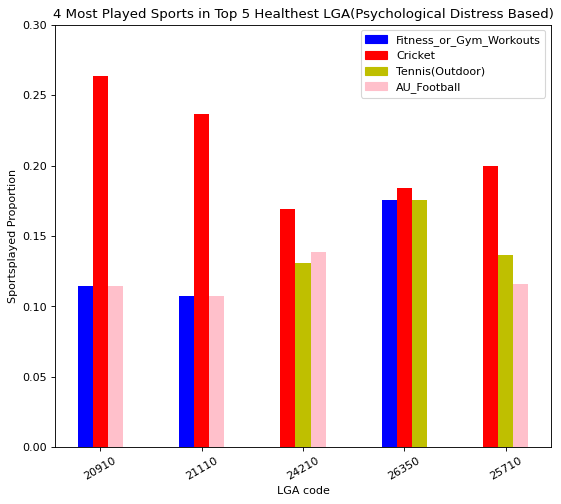

In [75]:
# select 5 LGA with best performance in psychological distress 
TOP5_LGA = JOINED_2.sort_values('psych_dstrs_2_asr').iloc[:5,]['lga_code'].to_list()
# top 3 sports played in each of these 5 LGAs
GROUPBY_LGA_AND_SPORT1 = GROUPBY_LGA_AND_SPORT.loc[TOP5_LGA]
GROUPBY_LGA_AND_SPORT1.sort_values(['lga_code','percentage'],ascending=False).groupby('lga_code').head(3)
# Plot
from matplotlib.pyplot import figure
figure(figsize=(8, 7), dpi=80)
Fitness = [0.114865,0.107527,0,0.175439,0]
Cricket = [0.263514,0.236559,0.169231,0.184211,0.200000]
Tennis_Outerdoor=[0,0,0.130769,0.175439,0.136842]
AU_Football = [0.114865,0.107527,0.138462,0,0.115789]
plt.bar(np.arange(len(Fitness))*2-0.3, Fitness, width=0.3,color='b')
plt.bar(np.arange(len(Cricket))*2-[0,0,0.3,0,0.3], Cricket, width=0.3, color='r')
plt.bar(np.arange(len(Tennis_Outerdoor))*2+0.3-[0,0,0.3,0,0.3],Tennis_Outerdoor, width=0.3, color='y')
plt.bar(np.arange(len(AU_Football))*2+0.3,AU_Football, width=0.3, color='pink')
plt.xticks(np.arange(len(TOP5_LGA))*2, TOP5_LGA, rotation=30)
colors = ['b','r','y','pink']      
labels = ['Fitness_or_Gym_Workouts','Cricket','Tennis(Outdoor)','AU_Football']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylim(0,0.3)
plt.ylabel("Sportsplayed Proportion")
plt.xlabel("LGA code")
plt.title("4 Most Played Sports in Top 5 Healthest LGA(Psychological Distress Based)")
plt.savefig("obes")

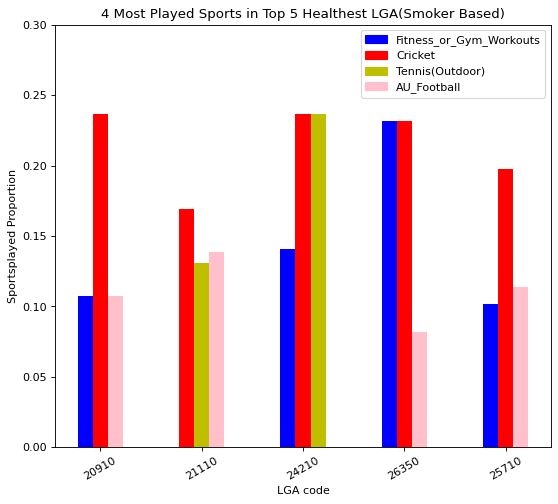

In [76]:

# top 3 sports played in each of these 5 LGAs
GROUPBY_LGA_AND_SPORT1 = GROUPBY_LGA_AND_SPORT.loc[TOP5_LGA]
GROUPBY_LGA_AND_SPORT1.sort_values(['lga_code','percentage'],ascending=False).groupby('lga_code').head(3)
# Plot
from matplotlib.pyplot import figure
figure(figsize=(8, 7), dpi=80)
Fitness = [0.107527,0,0.140625,0.231343,0.101796]
Cricket = [0.236559,0.169231,0.236559,0.231343,0.197605]
Tennis_Outerdoor=[0,0.130769,0.236559,0,0]
AU_Football = [0.107527,0.138462,0,0.082090,0.113772]
plt.bar(np.arange(len(Fitness))*2-0.3, Fitness, width=0.3,color='b')
plt.bar(np.arange(len(Cricket))*2-[0,0.3,0,0,0], Cricket, width=0.3, color='r')
plt.bar(np.arange(len(Tennis_Outerdoor))*2+0.3-[0,0.3,0,0,0],Tennis_Outerdoor, width=0.3, color='y')
plt.bar(np.arange(len(AU_Football))*2+0.3,AU_Football, width=0.3, color='pink')
plt.xticks(np.arange(len(TOP5_LGA))*2, TOP5_LGA, rotation=30)
colors = ['b','r','y','pink']      
labels = ['Fitness_or_Gym_Workouts','Cricket','Tennis(Outdoor)','AU_Football']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
plt.legend(handles, labels)
plt.ylim(0,0.3)
plt.ylabel("Sportsplayed Proportion")
plt.xlabel("LGA code")
plt.title("4 Most Played Sports in Top 5 Healthest LGA(Smoker Based)")
plt.savefig("smk")

In [77]:

num_facility_per_km2 = JOINED_2['num_facility_per_km2'].to_list()
lw_excse_2_asr = JOINED_2['lw_excse_2_asr'].to_list()
obese_p_2_asr = JOINED_2['obese_p_2_asr'].to_list()
hbld_pres_2_asr = JOINED_2['hbld_pres_2_asr'].to_list()
psych_dstrs_2_asr = JOINED_2['psych_dstrs_2_asr'].to_list()
smkrs_p_2_asr = JOINED_2['smkrs_p_2_asr'].to_list()
alchl_p_2_asr = JOINED_2['alchl_p_2_asr'].to_list()
wst_meas_p_2_asr = JOINED_2['wst_meas_p_2_asr'].to_list()


lw_excse_2_asr_class = []
obese_p_2_asr_class = []
hbld_pres_2_asr_class = []
psych_dstrs_2_asr_class = []
smkrs_p_2_asr_class = []
alchl_p_2_asr_class = []
wst_meas_p_2_asr_class = []


#classify the Estimated number of people who did low or no exercise into two classes
for i in range(len(lw_excse_2_asr)):
    if lw_excse_2_asr[i] >= 64.4175:
        lw_excse_2_asr_class.append("high") 
    else:
        lw_excse_2_asr_class.append("low")
        
#classify the Estimated number of obese people into two classes
for i in range(len(obese_p_2_asr)):
    if obese_p_2_asr[i] >= 26.04:
        obese_p_2_asr_class.append("high") 
    else:
        obese_p_2_asr_class.append("low")
        
#classify the Estimated number of people with high blood pressure into two classes
for i in range(len(hbld_pres_2_asr)):
    if hbld_pres_2_asr[i] >= 23.9075:
        hbld_pres_2_asr_class.append("high") 
    else:
        hbld_pres_2_asr_class.append("low")
    
#classify the Estimated number of people with psychological distress into two classes
for i in range(len(psych_dstrs_2_asr)):
    if psych_dstrs_2_asr[i] >= 12.0525:
        psych_dstrs_2_asr_class.append("high") 
    else:
        psych_dstrs_2_asr_class.append("low")
        
#classify the Estimated number of people who were current smokers into two classes
for i in range(len(smkrs_p_2_asr)):
    if smkrs_p_2_asr[i] >= 15.340:
        smkrs_p_2_asr_class.append("high") 
    else:
        smkrs_p_2_asr_class.append("low")

#classify the alchoholic into two classes
for i in range(len(alchl_p_2_asr)):
    if alchl_p_2_asr[i] >= 15.49:
        alchl_p_2_asr_class.append("high") 
    else:
        alchl_p_2_asr_class.append("low")

#classify the Estimated number of people with a high risk waist measurement into two classes
for i in range(len(wst_meas_p_2_asr)):
    if wst_meas_p_2_asr[i] >= 61.09:
        wst_meas_p_2_asr_class.append("high") 
    else:
        wst_meas_p_2_asr_class.append("low")
        
#reshape the data into 1 dimension
X_1 = np.array(num_facility_per_km2)
y_1 = np.array(lw_excse_2_asr_class)
y_2 = np.array(obese_p_2_asr_class)
y_3 = np.array(hbld_pres_2_asr_class)
y_4 = np.array(psych_dstrs_2_asr_class)
y_5 = np.array(smkrs_p_2_asr_class)
y_6 = np.array(alchl_p_2_asr_class)
y_7 = np.array(wst_meas_p_2_asr_class)
X = X_1.reshape(-1, 1)
y_11 = y_1.reshape(-1,1)
y_22 = y_2.reshape(-1,1)
y_33 = y_3.reshape(-1,1)
y_44 = y_4.reshape(-1,1)
y_55 = y_5.reshape(-1,1)
y_66 = y_6.reshape(-1,1)
y_77 = y_7.reshape(-1,1)
        

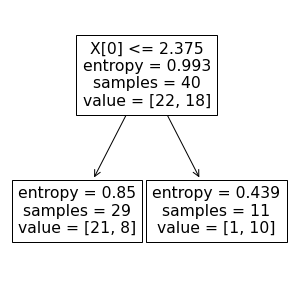

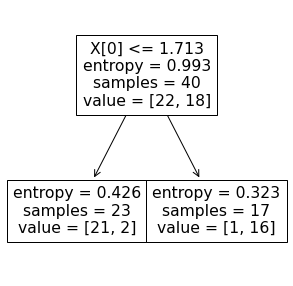

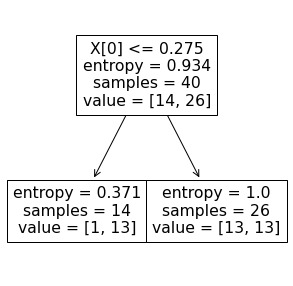

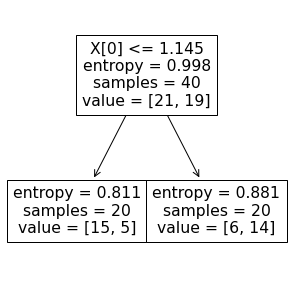

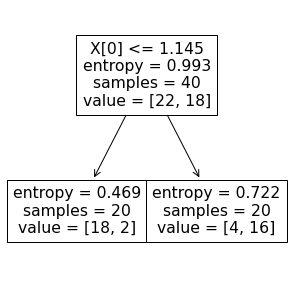

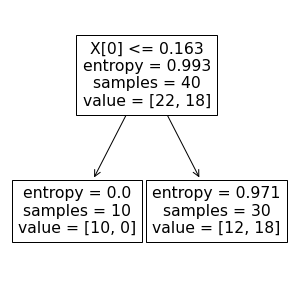

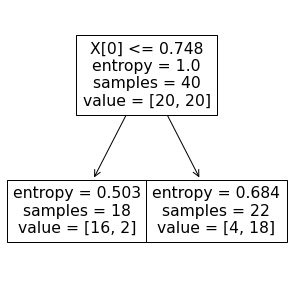

In [78]:

#plot the decision tree for the Estimated number of people who did low or no exercise
low_Exercise = tree.DecisionTreeClassifier(criterion="entropy",random_state=1, max_depth=1)
Fit_1 = low_Exercise.fit(X, y_11)
plt.figure(figsize=(5,5))
tree.plot_tree(Fit_1)
plt.savefig("lowexercise")
plt.show()


#plot the decision tree for the Estimated number of obese people
obesity = tree.DecisionTreeClassifier(criterion="entropy",random_state=1, max_depth=1)
Fit_2 = low_Exercise.fit(X, y_22)
plt.figure(figsize=(5,5))
tree.plot_tree(Fit_2)
plt.savefig("obesity")
plt.show()


#plot the decision tree for the Estimated number of people with high blood pressur
high_blood_pressure = tree.DecisionTreeClassifier(criterion="entropy",random_state=1, max_depth=1)
Fit_3 = low_Exercise.fit(X, y_33)
plt.figure(figsize=(5,5))
tree.plot_tree(Fit_3)

plt.savefig("highbloodpressure")
plt.show()

#plot the decison tree for the Estimated number of people with psychological distress
overweight = tree.DecisionTreeClassifier(criterion="entropy",random_state=1, max_depth=1)
Fit_4 = low_Exercise.fit(X, y_44)
plt.figure(figsize=(5,5))
tree.plot_tree(Fit_4)
plt.savefig("psychologicaldistress")
plt.show()

#plot the decison tree for the Estimated number of people who were current smokers
overweight = tree.DecisionTreeClassifier(criterion="entropy",random_state=1, max_depth=1)
Fit_5 = low_Exercise.fit(X, y_55)
plt.figure(figsize=(5,5))
tree.plot_tree(Fit_5)
plt.savefig("smoker")
plt.show()

#plot the decison tree for the alchoholic
overweight = tree.DecisionTreeClassifier(criterion="entropy",random_state=1, max_depth=1)
Fit_6 = low_Exercise.fit(X, y_66)
plt.figure(figsize=(5,5))
tree.plot_tree(Fit_6)
plt.savefig("alchoholic")
plt.show()

#plot the decison tree for the Estimated number of people with a high risk waist measurement
overweight = tree.DecisionTreeClassifier(criterion="entropy",random_state=1, max_depth=1)
Fit_7 = low_Exercise.fit(X, y_77)
plt.figure(figsize=(5,5))
tree.plot_tree(Fit_7)
plt.savefig("waistrisk")
plt.show()

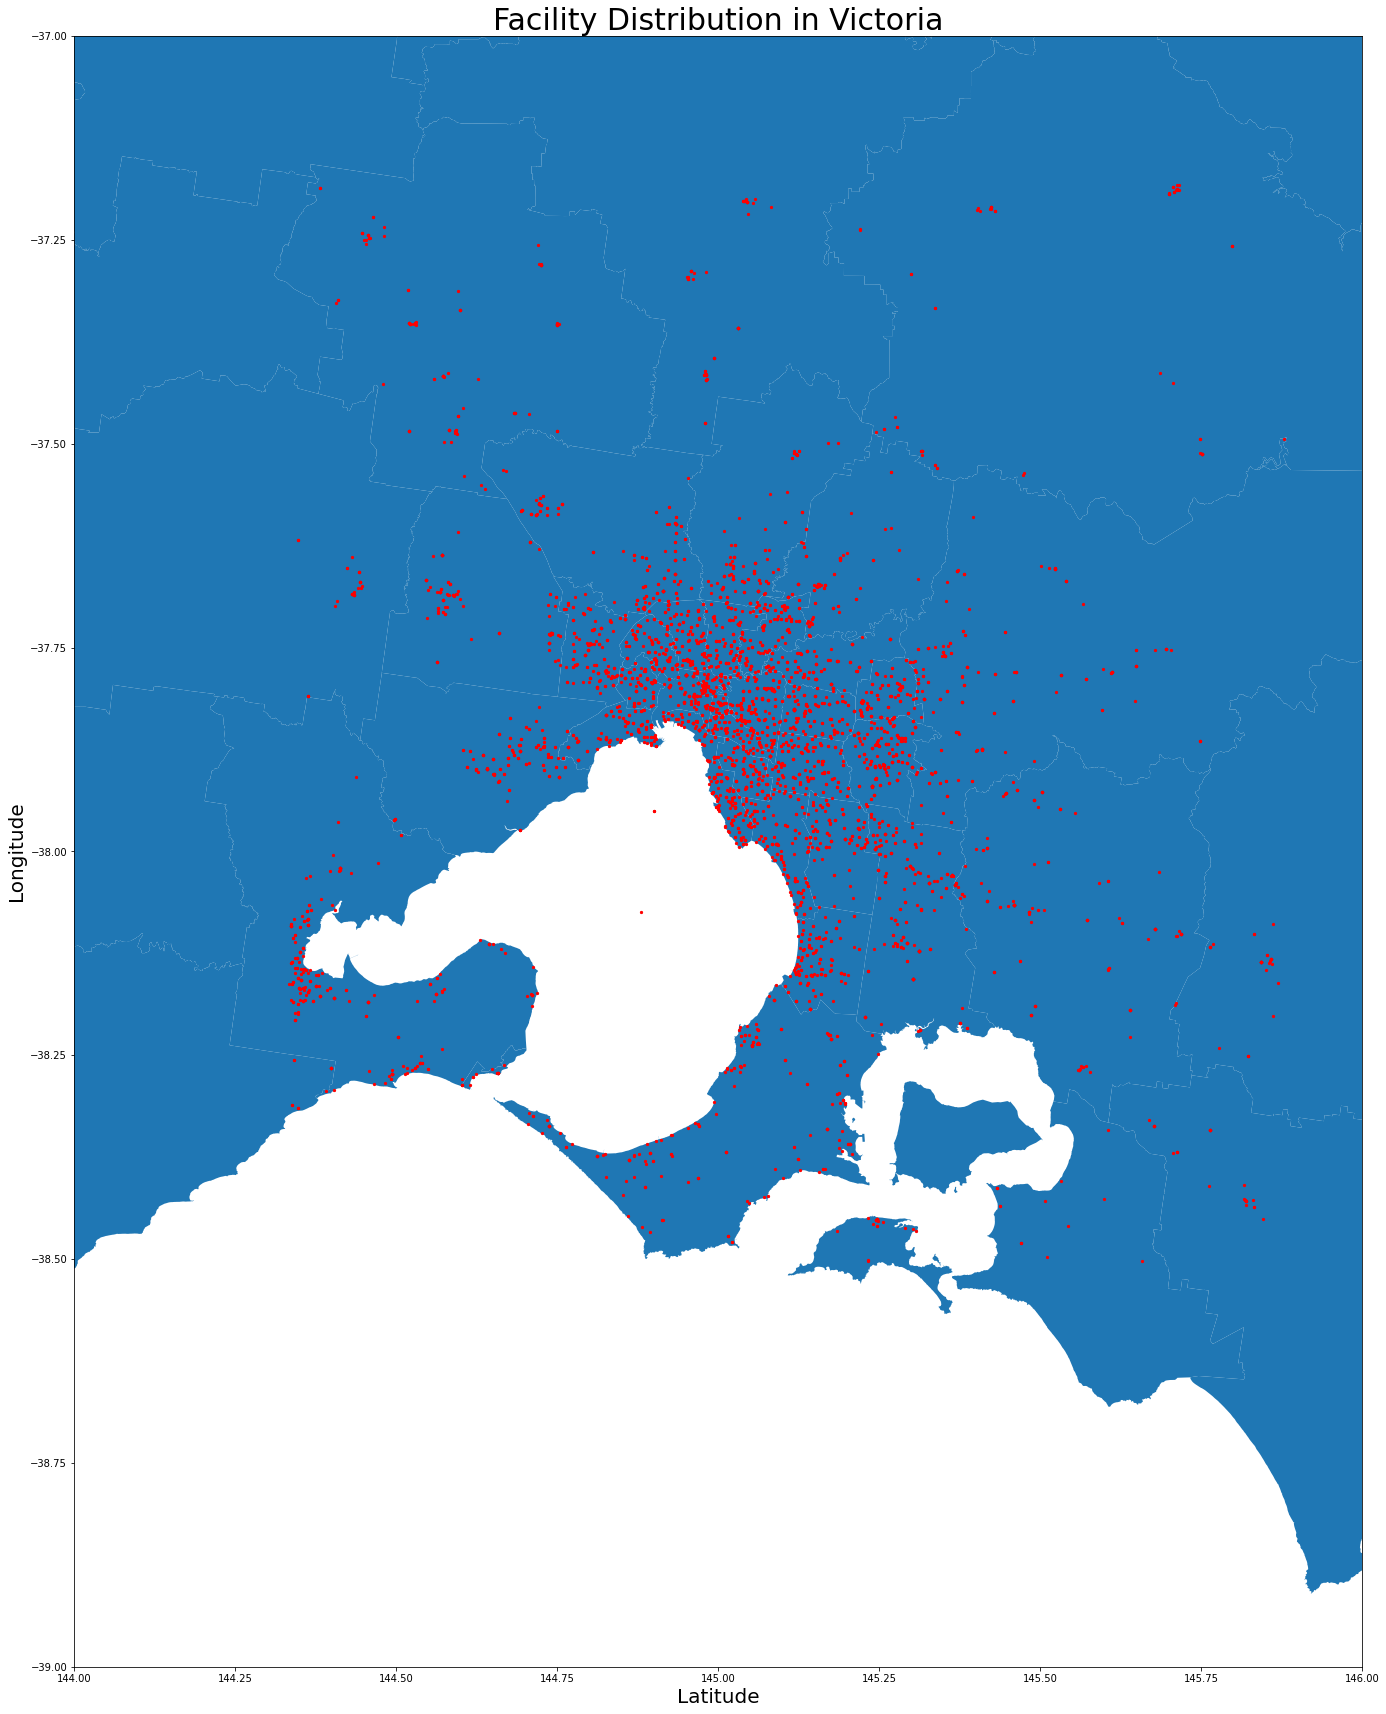

In [79]:
sport_map = gpd.read_file('Sport_facility_shape/8981b016-368c-4ba9-a747-a338a5fb6ca3.shp')
vic_map = gpd.read_file('Victoria_map_shape/VIC_LGA_POLYGON_SHP.shp')
fig, ax = plt.subplots(figsize = (30,30))

ax.set_xlim(144, 146)
ax.set_ylim(-39, -37)

vic_map.plot(ax = ax)
sport_map.plot(ax = ax, markersize = 5, color = 'red')
plt.title("Facility Distribution in Victoria",fontsize=30)
plt.xlabel("Latitude",fontsize=20)
plt.ylabel("Longitude",fontsize=20)
plt.savefig("map")